# Time Series Analysis with MXNet GluonTS

## Problem
A **"forecast"** is probablistic prediction of certain events in the future based on the past events. Forecasting is a common statistical and machine learning problem which is applied to variety of use cases (from supply/demand prediction to weather forecasts to financial forecasting). When doing forecasting of time-series data you need to consider following:
- How many previous events you want to consider when doing forecast (prediction context)?
- How far in the future you want to forecast (forecasting horizon);
- Is dataset used for forecasting univariate (i.e. single temporal variable available) or multivariate (i.e. several temporal variables available)?
- Are there any non-temporal features available?

In this lab, we'll predict future consumption of electricity for individual households based on historical data using [Electricity Load dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014). We'll use GluonTS toolkit and DeepAR model for it. we'll leverage Sagemaker Training and Hyperparameter Optimization (optional) for it.


# Prerequisites
- Skills: Familiarity with MXNet, Gluon, Python;
- Resource: Sagemaker Jupyter notebook, permissions to run Sagemaker distributed training jobs.


## GluonTS Toolkit
[Gluon Time Series](http://gluon-ts.mxnet.io/) (GluonTS) is Gluon toolkit for probabilistic time series modeling, focusing on deep learning-based models. GluonTS provides utilities for loading and iterating over time series datasets, state of the art models, and building blocks to define your own models and to quickly experiment. With GluonTS you can:
- Train and evaluate any of the built-in models on your own data, and quickly come up with a solution for your time series tasks.
- Use the provided abstractions and building blocks to create custom time series models, and rapidly benchmark them against baseline algorithms.

## DeepAR Algorithm

The Amazon SageMaker DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNN). RNN is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs.

Find DeepAR model architecture below ([source](https://arxiv.org/pdf/1704.04110.pdf)):

<center><img src='images/deepar.png' width=700></center> 

# Install GluonTS

Let's start by installing **gluonts** package. 

Please note, that if you see error with gluonts import after its successful installation, please restart your kernel (so it "pick up" a newly installed package) and retry.

In [1]:
# Install gluonts
!pip install gluonts

# test that it's installed
import gluonts

     |████████████████████████████████| 569 kB 24.1 MB/s eta 0:00:01
     |████████████████████████████████| 8.7 MB 15.4 MB/s eta 0:00:01
     |████████████████████████████████| 120 kB 73.6 MB/s eta 0:00:01
     |████████████████████████████████| 732 kB 59.4 MB/s eta 0:00:01
  Created wheel for holidays: filename=holidays-0.10.4-py3-none-any.whl size=124774 sha256=70f43aff3c3b4bfac7502ed313e1ec6769135e54dd3d05a9905c4469d5773aac
  Stored in directory: /home/ec2-user/.cache/pip/wheels/24/20/e0/beaaa13a665f8a4fa4bd61ad15293eb37ca88b187c7ae0e019
  Created wheel for pymeeus: filename=PyMeeus-0.3.7-py3-none-any.whl size=702876 sha256=c3337f5195f5f6eca29c2bb8e036341d3ebd44cb619da466a3c9f1385e1139ba
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e9/c3/07/d32faf16682e2cd245be46e4c54053c8c82fa9762f4a4bcc63
Successfully built holidays pymeeus
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


Now, let's import required packages

In [8]:
# MXNet/GluonTS imports
import gluonts
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.trainer import Trainer
from gluonts.dataset.util import to_pandas
import mxnet as mx

# Standard imports
import os
from pathlib import Path
import boto3

# Data Processing

### Using GluonTS built-in datasets

GluonTS provides convenient mechanisms to manipulate time-series datasets. It also comes with number built-in datasets. Let's start by exploring available datasets. 

In [9]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


GluonTS DataSet object consist of 3 members:
- **dataset.train** is an iterable collection of data entries used for training. Each entry corresponds to one time series.
- **dataset.test** is an iterable collection of data entries used for validation. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- **dataset.metadata** contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

Let's select _electricity_ dataset and explore it's properties. 
**Please note**, it will take a few minutes to download dataset.

In [10]:
# This will take ~3-5 minutes
dataset_name = 'electricity'
data_dir = 'gluonts_data' # define local repository where you'd like to store datasets.

if not os.path.exists(data_dir):
    os.mkdir(data_dir)
data_path = Path(os.getcwd()+"/"+data_dir)
    
dataset = get_dataset("electricity", regenerate=False, path=data_path)
print(dataset.metadata)

freq='1H' target=None feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='321')] feat_static_real=[] feat_dynamic_real=[] feat_dynamic_cat=[] prediction_length=24


### Explore Electricity Dataset

Now, let's review test and training time series of electricity dataset.

In [5]:
import matplotlib.pyplot as plt

# get the first time series in the training set
train_entry = next(iter(dataset.train))
train_entry.keys()

# get the first time series in the test set
test_entry = next(iter(dataset.test))
test_entry.keys()

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

In [6]:
# get only last 48 and 72 hours for train and test respectively
train_48 = train_series[-48:]
test_72 = test_series[-72:]

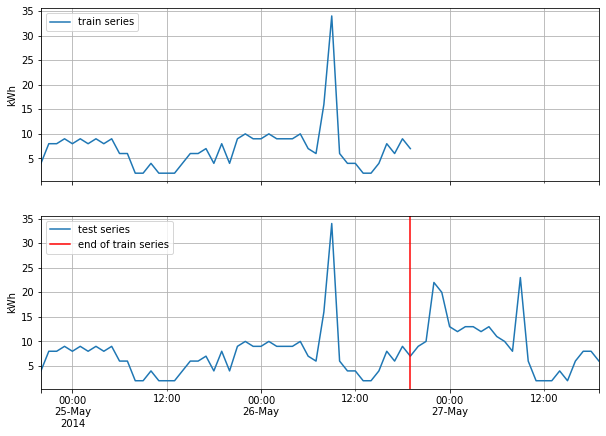

Length of forecasting window in test dataset: 24
Recommended prediction horizon: 24
Frequency of the time series: 1H


In [7]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_48.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].set_ylabel('kWh')
ax[0].legend(["train series"], loc="upper left")

test_72.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].set_ylabel('kWh')
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

### Upload dataset to S3

As we will leverage Amazon Sagemaker for training and inference, it's more convenient and time efficient to store dataset in shared S3 bucket. Code below uploads Electicity data set to specified S3 bucket.

## LAB INSTRUCTION

Update **bucket**, **region**, and **prefix** variables below. Please make sure that:
- bucket has unique name and doesn't exist;
- use region where your notebook instance is deployed.

In [5]:
from sagemaker.session import Session

session=Session()

bucket=session.default_bucket()

prefix = "gluonts-data"
region=session.boto_region_name
print(bucket)

sagemaker-us-east-1-553020858742


In [ ]:
import boto3
import os
from sagemaker.session import Session

# bucket creation is slightly different for us-east-1 vs other regions
if region=="us-east-1":
    os.environ["AWS_DEFAULT_REGION"] = region
    s3_client = boto3.client('s3')
    s3_client.create_bucket(Bucket=bucket)
else:
    s3_client = boto3.client('s3', region_name=region)
    location = {'LocationConstraint': region}
    s3_client.create_bucket(Bucket=bucket,
                            CreateBucketConfiguration=location)

s3_bucket_resource = boto3.resource('s3').Bucket(bucket)
s3_data_uri = "s3://{}/{}".format(bucket, prefix) # composing URI for bucket above

# Define local files for S3 upload
local_metadata = os.path.join(data_path, dataset_name, 'metadata.json')
local_train_file = os.path.join(data_path, dataset_name, 'train','data.json')
local_test_file = os.path.join(data_path, dataset_name, 'test','data.json')

s3_metadata = os.path.join(prefix, 'data', 'metadata.json')
s3_bucket_resource.Object(s3_metadata).upload_file(local_metadata)

s3_train_file = os.path.join(prefix, 'data', 'train', 'data.json')
s3_bucket_resource.Object(s3_train_file).upload_file(local_train_file)

s3_test_file = os.path.join(prefix, 'data', 'test', 'data.json')
s3_bucket_resource.Object(s3_test_file).upload_file(local_test_file)

In [ ]:
# Let's confirm that data was actually uploaded to S3
for my_bucket_object in s3_bucket_resource.objects.all():
    print(my_bucket_object)

# Sagemaker training

Sagemaker provides fully managed training and inference ecosystem. Read about it [here](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html). In this lab, we'll learn how to use Sagemaker managed capabilities to train and use at inference time for trained GluonTS models.

GluonTS is a part of MXNet ecosystem, so we'll use Sagemaker [MXNet container](https://github.com/aws/sagemaker-mxnet-container) for training and inference. The Amazon SageMaker Python SDK MXNet estimators and models and the Amazon SageMaker open-source MXNet container make writing a MXNet script and running it in Amazon SageMaker easier.

To successfully schedule a Sagemaker training job, we need to specify a training script which will be executed on remote Sagemaker nodes. Execute cell below to review already prepared training script. Read [this article](https://sagemaker.readthedocs.io/en/stable/using_mxnet.html#prepare-an-mxnet-training-script) to learn more about requirements for MXnet training scripts.

Please note following key blocks related to training process:
- `if __name__ == "__main__"` - this code block is executed when we run our training code as script via `python code.py` command. In this block we parse training hyperparameters, call methods to initiate model training and evaluation;
- `train()` method implements main training logic;
- `evaluate()` method performs evaluation of trained model on test dataset;
- `save_trained_model()` methods saves trained model for future use.

In [13]:
!pygmentize src/gluonts_training_script.py

# Standard library imports
from pathlib import Path
import argparse
import os
import json
import logging
from itertools import islice
from random import randint
from pathlib import Path
import pandas as pd


# MXNet & GluonTS imports
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.util import to_pandas
import mxnet as mx
from gluonts.dataset import common
from gluonts.dataset.repository import datasets
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.model.predictor import Predictor
from gluonts.dataset.common import ListDataset


# Logging: print logs analogously to Sagemaker.
logger = logging.getLogger(__name__)
    

def _get_local_dataset(dataset_location=None):
    """
    This method returns dataset stored locally by Sagemaker. 
    If no param dataset_location is not provide

Now, once we have understanding about our training & inference script, let's schedule our first Sagemaker training job.

## LAB INSTRUCTIONS

Define following parameters of distributed training:
- set **train_instance_type** as **'ml.p3.2xlarge'** - this is an instance type Sagemaker will use for training;
- set **train_instance_count** as **1** - this is a training script Sagemaker will run on training node(s);
- set **source_dir** as **'src'** - Sagemaker will upload content of this folder to training node(s);
- set **entry_point** as **'gluonts_training_script.py'** - Sagemaker will use this script to run training & inference.

In [14]:
train_instance_type =   "ml.p3.2xlarge"   # follow instructions above
train_instance_count =  1   # follow instructions above
source_dir =        "src"       # follow instructions above
entry_point=  "gluonts_training_script.py"             # follow instructions above

Sagemaker allows you to define specific metrics which will be scraped from training logs and displayed in training jobs console.

In [15]:
# Define metrics which we want Sagemaker to capture during training
metric_definitions = [{'Name': 'final-loss', 'Regex': 'Final loss: ([0-9\.]+)'},
                      {'Name': 'avg-epoch-loss', 'Regex': 'avg_epoch_loss=([0-9\.]+)' },
                      {'Name': 'MASE', 'Regex': '\'MASE\': ([0-9\.]+)'}, # mean absolute scaled error - mean absolute error of the forecast values, divided by the mean absolute error of the in-sample one-step naive forecast
                      {'Name': 'sMAPE', 'Regex': '\'sMAPE\': ([0-9\.]+)'}, # symmetric mean absolute percentage error
                      {'Name': 'MSE', 'Regex': '\'MSE\': ([0-9\.]+)'},
                      {'Name': 'MAE_Coverage', 'Regex': '\'MAE_Coverage\': ([0-9\.]+)'}, 
                      {'Name': 'RMSE', 'Regex': '\'RMSE\': ([0-9\.]+)'}, #root mean square error
                      {'Name': 'NRMSE', 'Regex': '\'NRMSE\': ([0-9\.]+)'}, #root mean square error                      
                     ]

Let's also define some hyperparameters of DeepAR model

## LAB INSTRUCTIONS

Define following parameters of distributed training:
- set **epochs** to **10**;
- set **num-cells** to **20** - this is number of units;
- set **num-layers** to **2** - this is number of RNN layers;
- set **dropout** to **0.2**

In [16]:
hyperparameters={
              'epochs':    10   , # follow instructions above
              'num-cells':  20  , # follow instructions above
              'num-layers':  2 , # follow instructions above
              'dropout':     0.2   # follow instructions above
          }

In [ ]:
import io
import os
import json
import zipfile
import urllib

import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet import MXNet
from sagemaker.session import Session
from random import randint # to generate random ids for sagemaker jobs. TODO add some hashing function that guarantees that the won't be duplicates
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

role = get_execution_role()

mxnet_estimator = MXNet(entry_point= entry_point    ,# follow instuctions above
          source_dir= source_dir          ,# follow instuctions above  
          py_version='py3',
          role=role, 
          train_instance_count=train_instance_count,
          train_instance_type=train_instance_type,    
          hyperparameters=hyperparameters,
          input_mode='File',
          train_max_run=7200,
          metric_definitions=metric_definitions,
          framework_version='1.6.0')

mxnet_estimator.fit(inputs=s3_data_uri, logs=True)

### Evaluating training results

As part of our training job, we also evaluated trained model against unseen test data (3 different samples) and plotted the forecasts along with historical data. Sagemaker uploads all training job artifacts to S3. Let's retrieve training artifacts from S3 and review them. 

**Please note**, that charts below are rendered for 3 different data samples.

In [ ]:
from urllib.parse import urlparse # We'll use this package to parse S3 URI
import boto3

# Works for default S3 location for Sagemaker training job. If you provided custom location, you'll need ot modify it accordingly.
job_bucket = mxnet_estimator.latest_training_job.describe()['OutputDataConfig']['S3OutputPath']
job_path = mxnet_estimator.latest_training_job.job_name
artifact_uri = '{}{}'.format(job_bucket,job_path)
uri_object = urlparse(artifact_uri)

# Download archive with evaluation artifacts locally
archive_filename = "artifacts.tar.gz"
boto3.client(uri_object.scheme).download_file(uri_object.netloc, 
                                              "{}/output/output.tar.gz".format(job_path), 
                                              archive_filename)

# Untar artifact archive
import tarfile
tf = tarfile.open(archive_filename)
tf.extractall()

# Display images which match specific filename pattern "chart*.png"
from IPython.display import Image, display
import fnmatch 

pattern = 'chart*.png'
files = os.listdir('.')

listOfImageNames = []

for name in files:
    if fnmatch.fnmatch(name, pattern):
        listOfImageNames.append(name)

for imageName in listOfImageNames:
    display(Image(filename=imageName, width=800))

## Build MultiModel Forecasting APIs

In many instances we may want to have multiple forecasting models deployed behind the same endpoint. For example, when we are predicting retail sales in individual georgaphical areas, where each area will have its own forecasting model.

To host multiple models behing single Sagemaker endpoint, we'll use [Multi-Model Server](https://github.com/awslabs/multi-model-server). First, let's start from building serving container with MMS and GluonTS.

In [15]:
# loging to Sagemaker ECR with Deep Learning Containers
!aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-1.amazonaws.com
# loging to your private ECR
!aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 553020858742.dkr.ecr.us-east-1.amazonaws.com

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [ ]:
!./build_and_push.sh gluonts-serving latest Dockerfile.serving

## Create Inference Script

To serve models, we need to provide MMS with inference script which implements the logic of model loading, ser/deser of input and output inferences traffic, and running predictions.

In [135]:
! pygmentize serving.py

# Standard library imports
from pathlib import Path
import argparse
import os
import json
import logging
from itertools import islice
from random import randint
from pathlib import Path
import pandas as pd


# MXNet & GluonTS imports
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.util import to_pandas
import mxnet as mx
from gluonts.dataset import common
from gluonts.dataset.repository import datasets
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.model.predictor import Predictor
from gluonts.dataset.common import ListDataset


# Logging: print logs analogously to Sagemaker.
logger = logging.getLogger(__name__)

class ModelHandler(object):
    """
    Keras VGG pre-trained model classifier
    """

    def __init__(self):
        self.initialized = False
        self.model = Non

## Package Model

MMS requires model to be packaged. So let's download trained model first.

In [133]:
! aws s3 cp s3://sagemaker-us-east-1-553020858742/mxnet-training-2020-12-11-23-40-10-418/output/model.tar.gz model1.tar.gz
! aws s3 cp s3://sagemaker-us-east-1-553020858742/mxnet-training-2020-12-11-23-40-10-418/output/model.tar.gz model2.tar.gz

download: s3://sagemaker-us-east-1-553020858742/mxnet-training-2020-12-11-23-40-10-418/output/model.tar.gz to ./model1.tar.gz
download: s3://sagemaker-us-east-1-553020858742/mxnet-training-2020-12-11-23-40-10-418/output/model.tar.gz to ./model2.tar.gz


In [136]:
! mkdir -p model2 && tar -xzf model2.tar.gz -C model2
! mkdir -p model1 && tar -xzf model1.tar.gz -C model1

# copy inference scripts to models directory
! cp serving.py model1/serving.py
! cp serving.py model2/serving.py

In [137]:
# Archive models

!model-archiver --model-name model1 -f --model-path model1 --handler serving:handle --export-path model_store    
!model-archiver --model-name model2 -f --model-path model2 --handler serving:handle --export-path model_store    

WARNING - Overwriting model_store/model1.mar ...


## Start server locally

In [ ]:
!multi-model-server --start --models model1=model1.mar, model2=model2.mar --model-store model_store
#multi-model-server --stop

In [25]:
! pip install requests

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [ ]:
### Test inference on model1 and model2

In [141]:

# send inference request
from sagemaker.predictor import json_serializer, json_deserializer
import requests

# Prepare data to send over wire for forecasting
test_entry = next(iter(dataset.test))
test_series = to_pandas(test_entry)
# json_data = test_series.to_json(date_format="epoch", date_unit='s' )
json_data = test_series.to_json(date_format="iso")
dict_from_json = json.loads(json_data)
formatted_dict = {k[:19]:v for k,v in dict_from_json.items()}
# payload = formatted_dict
payload = json_data


# # Parameters of Sagemaker predictors
content_type = 'application/json'
accept_type = None
headers = {'content-type': content_type, 'accept': accept_type}

url="http://127.0.0.1:8080"
model1_name="model1"
model2_name="model2"

response1 = requests.post(f"{url}/predictions/{model1_name}", data=payload, headers=headers)
response2 = requests.post(f"{url}/predictions/{model2_name}", data=payload, headers=headers)


In [142]:
print(response1.content)
print(response2.content)

b'{"predictions": [4.333353042602539, 1.5298157930374146, 6.825551509857178, 7.059480667114258, 11.032137870788574, 13.160388946533203, 12.286589622497559, 13.068629264831543, 17.015460968017578, 15.53531265258789, 18.708906173706055, 13.546443939208984, 19.270240783691406, 21.95366096496582, 10.91171932220459, 13.310141563415527, 13.148355484008789, 7.866537094116211, 10.869327545166016, 14.35938549041748, 8.416492462158203, 13.05472469329834, 8.237415313720703, 7.409308910369873]}'
b'{"predictions": [4.333353042602539, 1.5298157930374146, 6.825551509857178, 7.059480667114258, 11.032137870788574, 13.160388946533203, 12.286589622497559, 13.068629264831543, 17.015460968017578, 15.53531265258789, 18.708906173706055, 13.546443939208984, 19.270240783691406, 21.95366096496582, 10.91171932220459, 13.310141563415527, 13.148355484008789, 7.866537094116211, 10.869327545166016, 14.35938549041748, 8.416492462158203, 13.05472469329834, 8.237415313720703, 7.409308910369873]}'


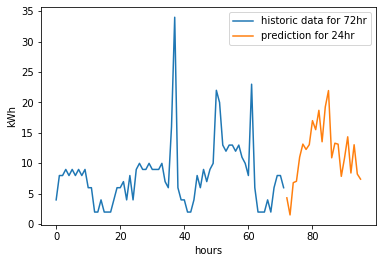

In [140]:
import numpy as np

historic_72 = test_series.tolist()[-72:]
predicted_24 = json.loads(response.content)['predictions']

plt.plot(np.arange(72), historic_72)
plt.plot(np.arange(72, 96), predicted_24)
plt.legend(['historic data for 72hr', 'prediction for 24hr'], loc='upper right')
plt.ylabel('kWh')
plt.xlabel('hours')

plt.show()

In [ ]:
!curl "http://localhost:8081/models/model1"

In [ ]:
!curl -X OPTIONS http://localhost:8080

# [DEPRECATED] Creating forecasting APIs

To serve any model using Sagemaker managed inference endpoints, you will need to implement two key components in your training script: loading trained model and model serving. Sagemaker supports following Python methods to implement these components:

- **model_fn()** - This method deserialize model artifacts into trained model which will be used during inference. If you don’t provide a model_fn function, the model server uses a default model_fn function. The default function works with MXNet Module model objects saved via the default save function. As in this lab we are using built-in GluonTS model and not MXNet Module model, we'll need to implement custom **model_fn**.

- **transform_fn(model, request_body, content_type, accept_type)** - This method request from end user and returns predictions. This one function should handle processing the input, performing a prediction, and processing the output. The return object should be one of the following: 
    - a tuple with two items: the response data and accept_type (the content type of the response data), OR
    - the response data: (the content type of the response is set to either the accept header in the initial request or default to “application/json”)

See more details on preparing inference script for Sagemaker endpoint [here](https://sagemaker.readthedocs.io/en/stable/using_mxnet.html#for-versions-1-3-and-higher).

In [ ]:
from sagemaker.predictor import json_serializer, json_deserializer

predictor = mxnet_estimator.deploy(initial_instance_count=1, 
                                   instance_type="ml.c4.xlarge"
                                  )

In [ ]:
from sagemaker.predictor import json_serializer, json_deserializer

# Prepare data to send over wire for forecasting
test_entry = next(iter(dataset.test))
test_series = to_pandas(test_entry)
json_data = test_series.to_json()


# Parameters of Sagemaker predictors
predictor.content_type = 'application/json'
predictor.deserializer = json_deserializer
predictor.serializer = None # If None, then ByteSerializer is chosen.


# Calling predictor
result = predictor.predict(json_data)

Now let's plot our predictions along with historical data.

In [ ]:
historic_72 = test_series.tolist()[-72:]
predicted_24 = result['predictions']

plt.plot(np.arange(72), historic_72)
plt.plot(np.arange(72, 96), predicted_24)
plt.legend(['historic data for 72hr', 'prediction for 24hr'], loc='upper right')
plt.ylabel('kWh')
plt.xlabel('hours')

plt.show()

In the end, let's delete forecasting endpoint not avoid any extra costs.

In [ ]:
predictor.delete_endpoint()

# HyperParameter Optimization (optional)

Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose.

Let's schedule tuning job and explore which combination of hypterparameters leads to better results.

**Note**: hyperparameter tuning will take significant time. You can manage training time by chaning max_jobs and max_parallel_jobs.

In [ ]:
# Define ranges for tunable parameters. Note, some of parameters have logarithmic scale.
hyperparameter_ranges = {
    'context-length' : IntegerParameter(12, 70),
    'dropout' :  ContinuousParameter(0, 0.5),
    'num-layers' : IntegerParameter(1, 20, scaling_type='Logarithmic'),
    'num-cells' : IntegerParameter(20, 200, scaling_type='Logarithmic'),
    'use-static-features': CategoricalParameter([True, False])
}

# Define metrics which Sagemaker needs to capture during training.
metric_definitions = [{'Name': 'final-loss', 'Regex': 'Final loss: ([0-9\.]+)'},
                      {'Name': 'avg-epoch-loss', 'Regex': 'avg_epoch_loss=([0-9\.]+)' },
                      {'Name': 'MASE', 'Regex': '\'MASE\': ([0-9\.]+)'}, # mean absolute scaled error - mean absolute error of the forecast values, divided by the mean absolute error of the in-sample one-step naive forecast
                      {'Name': 'sMAPE', 'Regex': '\'sMAPE\': ([0-9\.]+)'}, # symmetric mean absolute percentage error
                      {'Name': 'RMSE', 'Regex': '\'RMSE\': ([0-9\.]+)'}, # root mean square error
                      {'Name': 'NRMSE', 'Regex': '\'NRMSE\': ([0-9\.]+)'}, # normalized root mean square error                      
                     ]


## LAB INSTRUCTIONS
- set **objective_metric_name** as 'NRMSE' - normalized root square error. Sagemaker will use this metric to define which combination of hyperparameters is the best;
- set **max_parallel_jobs** as 2 - this is number of remote nodes which Sagemaker will use for training;
- set **max_jobs** as 10 - this is total number of training jobs and hyperparameter combinations which Sagemaker will execute;
- set **'epochs'** as '5' - this number of epochs in each training jobs.

In [ ]:
objective_metric_name =      # follow instructions above

hpo_model = MXNet(entry_point=entry_point,
          source_dir=source_dir,
          py_version='py3',
          role=role, 
          train_instance_count=1, 
          train_instance_type=train_instance_type,
          hyperparameters={
              'epochs' :      , # follow instructions above
              'use-static-features' : False,
          },
          input_mode='File',
          train_max_run=7200,
          framework_version='1.6.0')


hpo_tuner = HyperparameterTuner(hpo_model,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=           , # follow instructions above
                            max_parallel_jobs=  , # follow instructions above
                            objective_type="Minimize"
                           )

# HPO training
hpo_tuner.fit(inputs=s3_data_uri)

## Summary of Lab
During this lab you learned following:
- how to work preprocess time-series data using GluonTS;
- how to use built-in models in GluonTS and DeepAR specifically;
- how to do distirbuted training and hyperparameter tuning using Sagemaker.
